In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import tree

In [3]:
#data for google colabs
#training_set= pd.read_csv('/content/drive/My Drive/spotify/spotify_data/train_data_20.csv')
#track_data = pd.read_csv('/content/drive/My Drive/spotify/spotify_data/track_feats.csv')

In [4]:
training_set = pd.read_csv("train_data_20.csv")
track_data = pd.read_csv("track_feats.csv")

In [5]:
training_set.rename(columns = {'track_id_clean':'track_id'},inplace=True)

In [6]:
main = pd.merge(training_set,track_data)

main.head(5)

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.000000,1.0,t_1a73002a-d065-4a33-b98a-a3b0443310be,1,1,1,0,0,0,...,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
1,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.052632,1.0,t_1a73002a-d065-4a33-b98a-a3b0443310be,0,0,0,0,0,0,...,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
2,63_0000c758-b61f-4966-9013-723f8e221c2e,0.210526,1.0,t_1a73002a-d065-4a33-b98a-a3b0443310be,0,0,0,1,1,1,...,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
3,63_002bfc14-d51f-4cdd-879a-eae059632e97,0.052632,1.0,t_1a73002a-d065-4a33-b98a-a3b0443310be,1,1,1,0,0,1,...,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
4,63_002bfc14-d51f-4cdd-879a-eae059632e97,0.105263,1.0,t_1a73002a-d065-4a33-b98a-a3b0443310be,0,0,0,0,0,0,...,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306


In [5]:
main.drop(['session_id','track_id','skip_1','skip_2','skip_3'],axis=1,inplace=True)

In [33]:
main.dtypes

session_id                        object
session_position                 float64
session_length                   float64
track_id                          object
skip_1                             int64
                                  ...   
acoustic_vector_6                float64
acoustic_vector_7                float64
premium                            int64
hist_user_behavior_is_shuffle      int64
not_skipped                        int64
Length: 69, dtype: object

In [67]:
for item in main.columns:
    print(item,min(main[item]),max(main[item]))


session_position 0.0 1.0
session_length 1.0 1.0
context_switch 0 1
no_pause_before_play 0 1
short_pause_before_play 0 1
long_pause_before_play 0 1
hist_user_behavior_n_seekfwd -0.1649147349661557 27.37858121472395
hist_user_behavior_n_seekback -0.16531891838347845 42.456995337990044
hour_of_day 0.0 1.0
context_type_catalog 0 1
context_type_charts 0 1
context_type_editorial_playlist 0 1
context_type_personalized_playlist 0 1
context_type_radio 0 1
context_type_user_collection 0 1
hist_user_behavior_reason_start_appload 0 1
hist_user_behavior_reason_start_backbtn 0 1
hist_user_behavior_reason_start_clickrow 0 1
hist_user_behavior_reason_start_endplay 0 1
hist_user_behavior_reason_start_fwdbtn 0 1
hist_user_behavior_reason_start_playbtn 0 1
hist_user_behavior_reason_start_remote 0 1
hist_user_behavior_reason_start_trackdone 0 1
hist_user_behavior_reason_start_trackerror 0 1
hist_user_behavior_reason_end_appload 0 0
hist_user_behavior_reason_end_backbtn 0 1
hist_user_behavior_reason_end_cl

In [7]:
#Categorical data encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
notskipped = le.fit_transform(main['not_skipped'])
premium = le.fit_transform(main['premium'])
#contexttype = le.fit_transform(main['context_type'])
#histstart = le.fit_transform(main['hist_user_behavior_reason_start'])
#histend = le.fit_transform(main['hist_user_behavior_reason_end'])
shuffle = le.fit_transform(main['hist_user_behavior_is_shuffle'])
#mode = le.fit_transform(main['mode'])

In [8]:
main.drop(['not_skipped','premium','hist_user_behavior_is_shuffle'],axis = 1,inplace=True)

In [9]:
#Covetring arrays to Series
premium = pd.Series(premium,name='premium')
notskipped = pd.Series(notskipped,name='not_skipped')
shuffle = pd.Series(shuffle,name='hist_user_behavior_is_shuffle')
#mode = pd.Series(mode,name='mode')


In [10]:
#Concating the dataframe and the encoded data
main = pd.concat([main,premium,shuffle,notskipped],axis=1)


In [35]:
X = main[['session_position','session_length','no_pause_before_play','short_pause_before_play','long_pause_before_play',
          'hist_user_behavior_n_seekfwd','hist_user_behavior_n_seekback','hour_of_day','context_type_catalog', 
          'context_type_charts', 'context_type_editorial_playlist', 'context_type_personalized_playlist','context_type_radio',
          'context_type_user_collection', 'hist_user_behavior_reason_start_appload', 'hist_user_behavior_reason_start_backbtn',
          'hist_user_behavior_reason_start_clickrow', 'hist_user_behavior_reason_start_endplay','hist_user_behavior_reason_start_fwdbtn', 
          'hist_user_behavior_reason_start_playbtn', 'hist_user_behavior_reason_start_remote', 'hist_user_behavior_reason_start_trackdone', 
          'hist_user_behavior_reason_start_trackerror']]


In [44]:
X.dtypes

session_position                              float64
session_length                                float64
no_pause_before_play                            int64
short_pause_before_play                         int64
long_pause_before_play                          int64
hist_user_behavior_n_seekfwd                  float64
hist_user_behavior_n_seekback                 float64
hour_of_day                                   float64
context_type_catalog                            int64
context_type_charts                             int64
context_type_editorial_playlist                 int64
context_type_personalized_playlist              int64
context_type_radio                              int64
context_type_user_collection                    int64
hist_user_behavior_reason_start_appload         int64
hist_user_behavior_reason_start_backbtn         int64
hist_user_behavior_reason_start_clickrow        int64
hist_user_behavior_reason_start_endplay         int64
hist_user_behavior_reason_st

In [37]:
y =main['not_skipped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [38]:
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [39]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
predictrfc = rfc.predict(X_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [16]:
print("RF Test score:  %s" % rfc.score(X_test,y_test))

RF Test score:  0.825576356680998


In [17]:
with open("rfc_model_TestAcc.pkl","wb") as f:    
    pickle.dump(rfc,f)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictrfc))
print('\n')
print(classification_report(y_test,predictrfc))


[[189006  14047]
 [ 37476  54861]]


              precision    recall  f1-score   support

           0       0.83      0.93      0.88    203053
           1       0.80      0.59      0.68     92337

    accuracy                           0.83    295390
   macro avg       0.82      0.76      0.78    295390
weighted avg       0.82      0.83      0.82    295390



In [40]:
lgbm = LGBMClassifier(n_estimators=100000).fit(X_train,y_train, eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=10,verbose=True)


[1]	training's binary_logloss: 0.584828	valid_1's binary_logloss: 0.584544
Training until validation scores don't improve for 10 rounds
[2]	training's binary_logloss: 0.556686	valid_1's binary_logloss: 0.556302
[3]	training's binary_logloss: 0.534326	valid_1's binary_logloss: 0.533856
[4]	training's binary_logloss: 0.516232	valid_1's binary_logloss: 0.515686
[5]	training's binary_logloss: 0.501345	valid_1's binary_logloss: 0.500729
[6]	training's binary_logloss: 0.48904	valid_1's binary_logloss: 0.48835
[7]	training's binary_logloss: 0.478775	valid_1's binary_logloss: 0.478026
[8]	training's binary_logloss: 0.470241	valid_1's binary_logloss: 0.469427
[9]	training's binary_logloss: 0.463051	valid_1's binary_logloss: 0.462178
[10]	training's binary_logloss: 0.457027	valid_1's binary_logloss: 0.456095
[11]	training's binary_logloss: 0.451939	valid_1's binary_logloss: 0.45095
[12]	training's binary_logloss: 0.447694	valid_1's binary_logloss: 0.446649
[13]	training's binary_logloss: 0.44406

[112]	training's binary_logloss: 0.422617	valid_1's binary_logloss: 0.422018
[113]	training's binary_logloss: 0.422609	valid_1's binary_logloss: 0.422015
[114]	training's binary_logloss: 0.422597	valid_1's binary_logloss: 0.42202
[115]	training's binary_logloss: 0.422586	valid_1's binary_logloss: 0.422018
[116]	training's binary_logloss: 0.422577	valid_1's binary_logloss: 0.422016
[117]	training's binary_logloss: 0.422567	valid_1's binary_logloss: 0.422015
[118]	training's binary_logloss: 0.422559	valid_1's binary_logloss: 0.422015
[119]	training's binary_logloss: 0.422547	valid_1's binary_logloss: 0.422016
[120]	training's binary_logloss: 0.42254	valid_1's binary_logloss: 0.422016
[121]	training's binary_logloss: 0.422524	valid_1's binary_logloss: 0.422009
[122]	training's binary_logloss: 0.422517	valid_1's binary_logloss: 0.422009
[123]	training's binary_logloss: 0.422508	valid_1's binary_logloss: 0.422011
[124]	training's binary_logloss: 0.422496	valid_1's binary_logloss: 0.422008
[

In [41]:
print("LGBM Test score:  %s" % lgbm.score(X_test,y_test))

LGBM Test score:  0.8314025525576356


In [42]:
with open("lgbm_model.pkl","wb") as f:    
    pickle.dump(lgbm,f)


In [23]:
for pair in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%34s | % 5d" % pair)

                  session_position |   803
                       hour_of_day |   736
     hist_user_behavior_n_seekback |   606
      hist_user_behavior_n_seekfwd |   373
           short_pause_before_play |   188
      context_type_user_collection |   148
              no_pause_before_play |   134
                context_type_radio |   134
              context_type_catalog |   126
hist_user_behavior_reason_start_backbtn |   107
hist_user_behavior_reason_start_fwdbtn |   106
hist_user_behavior_reason_start_trackdone |   104
hist_user_behavior_reason_start_clickrow |    98
   context_type_editorial_playlist |    96
            long_pause_before_play |    64
context_type_personalized_playlist |    63
               context_type_charts |    49
hist_user_behavior_reason_start_appload |    46
hist_user_behavior_reason_start_remote |    27
hist_user_behavior_reason_start_trackerror |    18
hist_user_behavior_reason_start_endplay |    12
hist_user_behavior_reason_start_playbtn |    12
     

In [24]:
lgbm_feature_importances = [[p[0], int(p[1])] for p in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True)]

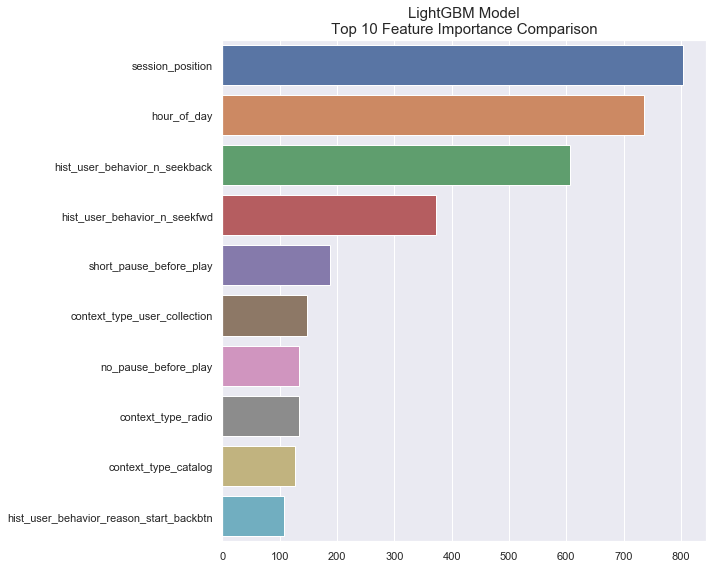

In [25]:
lgbm_feat = pd.DataFrame(lgbm_feature_importances,columns=['Feature','Importance'])

plt.figure(figsize=(10,8))
sns.barplot(
    "Importance",
    "Feature",
    data=lgbm_feat.head(10)
)
plt.title(
    "LightGBM Model\n Top 10 Feature Importance Comparison ",
    fontsize=15
)
plt.xlabel(
    "",
    fontsize=15
)
plt.ylabel(
    "",
    fontsize=15
)
# plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("lgbm_feature_importance_top10.png")
# plt.show()

In [30]:
print("LightGBM Confusion Matrix")
print(confusion_matrix(
    y_test,
    lgbm.predict(X_test)
) / sum(y_test.shape))

LightGBM Confusion Matrix
[[0.64737127 0.04003521]
 [0.12856224 0.18403128]]
